# Adaptive Clustering based Intrusion Detection


## Imports

In [1]:
#!/usr/bin/env python

__author__ = "Alec F."
__license__ = "GPL"
__version__ = "1.0.1"


import os
import sys
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from core.models.network import AdaptiveClustering
from core.utils.misc import extend_dataset
from core.utils import Dataset

import json

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from core.models.RandomForest import RandomForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as prf, accuracy_score

from pprint import pprint

from codecarbon import track_emissions
from datetime import datetime
import time


## Helpers

We use these helpers functions throughout all our experiments for simplify our main code and improve its readability. In all our experiments, our datasets are separated to approximately obtain a 70/30 train-test split from randomly sampled data. We use the pickle library to save our trained model and defined a set of metrics that are commonly used for classification tasks.

In [2]:
def load_dataset(dataset_path):
    global categories
    if not os.path.exists(dataset_path):
        print(f"Dataset not found: {dataset_path}")
        sys.exit(1)

    df = pd.read_csv(dataset_path, index_col=False, sep=",")

    
    # For binary classification, uncomment the following line
    df['Label.'] = np.where(df['Label.'] == 0, "Normal", "Attack")

    
    train_test_split = .3
    msk = np.random.rand(len(df)) < train_test_split
    train_df = df[msk]
    test_df = df[~msk]

    return train_df, test_df, df


def save_model(rf, filename):
    with open(filename, 'wb') as f:
        pkl.dump(rf, f)


def load_model(filename):
    with open(filename, 'rb') as f:
        m = pkl.load(f)
    return m


class metrics(object):

    def __init__(self, tp=None, tn=None, fp=None, fn=None):
        super(metrics, self).__init__()

        self.tp, self.tn, self.fp, self.fn = tp, tn, fp, fn

        self.metrics = {}

    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    def detection_rate(self):
        return self.tp / (self.tp + self.fn)

    def false_alarm_rate(self):
        return self.fp / (self.fp + self.tn)

    def precision(self):
        return self.tp / (self.tp + self.fp)

    def f1(self):
        prec = self.precision()
        rec = self.detection_rate()
        return 0 if (prec + rec) == 0 else 2 * (prec * rec) / (prec + rec)

    def get_metrics(self):
        self.metrics = {"Acc": self.accuracy(), "DR/Recall": self.detection_rate(), "FAR": self.false_alarm_rate(),
                        "PRECISION": self.precision(), "F1 SCORE": self.f1()}
        return self.metrics

## Adaptive Clustering - training function

We train our Adaptive Clustering network by following the exact settings provided in the paper.
However, we also implement an early stop mechanism allowing us to stop the training as soon as we achieve an acceptable loss.

In [3]:
@track_emissions
def train(X, y,j,dic_loss, lr=1e-4):

    dic_loss[f"entrainement_{j}"] = {}

    batch_size = 1024
    print("Adaptive training...")
    model_ = AdaptiveClustering(encoder_dims=[500, 60, 50], n_kernels=len(categories), kernel_size=10)
    model_.train()


    ds = Dataset(X, y)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=8)

    n_epoch = 4
    optimizer = None

    for i in range(n_epoch):
        iteration_losses = []
        
        for x, labels_ in dl:
            model_.zero_grad()
            _ = model_(x, labels_)
            if optimizer is None:
                optimizer = torch.optim.Adam(model_.parameters(), lr=lr)

            loss = model_.loss()
            loss_value = loss.item()

            iteration_losses.append(loss_value)

            loss.backward()
            optimizer.step()
        dic_loss[f"entrainement_{j}"][f"epoch_{i}"] = iteration_losses
        print(f"Iteration {i} | Loss {np.mean(iteration_losses)}")

    model_.eval()
    return model_

## Variables

Here we define some global variables to locate our datasets and point to our results directory.

In [2]:
root_path = './'

dataset_path = root_path + 'datasets/KDD/kddcup_corrige.csv'


results_path = root_path + f'results_60/'
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [3]:
model_path = results_path + 'trained_model.pkl'
separator = "-"*50

## Dataset
### Loading dataset

We load the preprocessed dataset as a pandas data frame and show the first few rows.

In [6]:
print(separator)
print("Loading dataset...")

train_df, test_df, df = load_dataset(dataset_path)
print("Done loading dataset")


--------------------------------------------------
Loading dataset...
Done loading dataset


In [7]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label.
0,0,0,0,0,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,Attack
1,0,0,0,0,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,Normal
2,0,0,0,0,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,Normal
3,0,0,0,0,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,Normal
4,0,0,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,Normal


### Preparing the data

We prepare the features to be in the correct format for our Adaptive Clustering network and the Random Forest Classifier.

The labels are separated from the training features and the order of the categories are kept track of in order to use them in the same order when evaluating the model on the testing set.

In [8]:
if os.path.exists(model_path + ".categories"):
    print(separator)
    print("Loading categories...")
    with open(model_path + ".categories", "r") as f:
        categories = json.load(f)
        print(f"categories loaded: {model_path}.categories")
    print("Done loading categories")
else:
    print("Creating categories...")
    categories = list(set(pd.factorize(train_df['Label.'])[1].values))
    print("Done creating categories...")

print("catégories de trafic traitées:",categories)

train_df_ = train_df.drop(['Label.'], axis=1)

X = train_df_.values.tolist()
y = train_df['Label.'].values.tolist()

X = torch.FloatTensor(np.array(X))

for i, l in enumerate(y):
    y[i] = categories.index(l)

y = torch.LongTensor(np.array(y))

cats = df['Label.'].copy()
y_ = df['Label.'].values
df.drop(['Label.'], axis=1, inplace=True)

Creating categories...
Done creating categories...
catégories de trafic traitées: ['Attack', 'Normal']


## Learning

### Training the model

We train our model until we achieve an acceptable loss and export an extended dataset with the cluster centers obtained from the Adaptive Clustering network. This would allow us to not have to retrain our network for every single execution.

In [9]:
dico_temps = {}
if not os.path.exists(model_path):
    global dic_loss
    dic_loss = {}
    print("Training model...")

    debut = time.time()
    date = datetime.now()
    model = train(X, y, 0,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_0"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_1 = train(X, y, 1,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_1"] = [date,durée]

    debut = time.time()
    date = datetime.now()
    model_2 = train(X, y, 2,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_2"] = [date,durée]

    debut = time.time()
    date = datetime.now()
    model_3 = train(X, y, 3,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_3"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_4 = train(X, y, 4,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_4"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_5 = train(X, y, 5,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_5"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_6 = train(X, y, 6,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_6"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_7 = train(X, y, 7,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_7"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_8 = train(X, y, 8,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_8"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_9 = train(X, y, 9,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_9"] = [date,durée]

    # Sauvegarde du dictionnaire_loss dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dic_loss.pkl", 'wb') as file:
        pkl.dump(dic_loss, file)

    # Sauvegarde du dictionnaire_temps dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dico_temps.pkl", 'wb') as file:
        pkl.dump(dico_temps, file)

    print("Done training model")


[codecarbon WARNING @ 15:17:37] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 15:17:37] [setup] RAM Tracking...
[codecarbon INFO @ 15:17:37] [setup] GPU Tracking...
[codecarbon INFO @ 15:17:37] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:17:37] [setup] CPU Tracking...
[codecarbon WARNING @ 15:17:37] No CPU tracking mode found. Falling back on CPU constant mode.


Training model...


[codecarbon INFO @ 15:17:38] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 15:17:38] >>> Tracker's metadata:
[codecarbon INFO @ 15:17:38]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 15:17:38]   Python version: 3.11.9
[codecarbon INFO @ 15:17:38]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 15:17:38]   Available RAM : 15.422 GB
[codecarbon INFO @ 15:17:38]   CPU count: 16
[codecarbon INFO @ 15:17:38]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 15:17:38]   GPU count: 1
[codecarbon INFO @ 15:17:38]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 15:17:57] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:17:57] Energy consumed for all GPUs : 0.000069 kWh. Total GPU Power : 16.430341012615987 W
[codecarbon INFO @ 15:17:57] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:17:57] 0.000187 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:18:12] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:18:12] Energy consumed for all GPUs : 0.000121 kWh. Total GPU Power : 12.483066534533895 W
[codecarbon INFO @ 15:18:12] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:18:12] 0.000356 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:18:27] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:18:27] Energy consumed for all GPUs : 0.000174 kWh. Total GPU Power : 12.783515619087

Iteration 0 | Loss 59.20488081034013


[codecarbon INFO @ 15:21:12] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:21:12] Energy consumed for all GPUs : 0.000824 kWh. Total GPU Power : 14.293298725869715 W
[codecarbon INFO @ 15:21:12] Energy consumed for all CPUs : 0.001313 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:21:12] 0.002474 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:21:27] Energy consumed for RAM : 0.000361 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:21:27] Energy consumed for all GPUs : 0.000885 kWh. Total GPU Power : 14.700649550594397 W
[codecarbon INFO @ 15:21:27] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:21:27] 0.002653 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:21:42] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:21:42] Energy consumed for all GPUs : 0.000948 kWh. Total GPU Power : 15.044925151287

Iteration 1 | Loss 0.02047489862953997


[codecarbon INFO @ 15:24:57] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:24:57] Energy consumed for all GPUs : 0.001695 kWh. Total GPU Power : 14.164061869816635 W
[codecarbon INFO @ 15:24:57] Energy consumed for all CPUs : 0.002720 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:24:57] 0.005114 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:25:12] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:25:12] Energy consumed for all GPUs : 0.001755 kWh. Total GPU Power : 14.29743742891141 W
[codecarbon INFO @ 15:25:12] Energy consumed for all CPUs : 0.002814 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:25:12] 0.005292 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:25:27] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:25:27] Energy consumed for all GPUs : 0.001815 kWh. Total GPU Power : 14.2864797850241

Iteration 2 | Loss 0.01234954386578374


[codecarbon INFO @ 15:28:27] Energy consumed for RAM : 0.001036 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:28:27] Energy consumed for all GPUs : 0.002496 kWh. Total GPU Power : 12.54152806110295 W
[codecarbon INFO @ 15:28:27] Energy consumed for all CPUs : 0.004033 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:28:27] 0.007565 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:28:42] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:28:42] Energy consumed for all GPUs : 0.002551 kWh. Total GPU Power : 13.299686014078743 W
[codecarbon INFO @ 15:28:42] Energy consumed for all CPUs : 0.004127 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:28:42] 0.007739 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:28:57] Energy consumed for RAM : 0.001084 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:28:57] Energy consumed for all GPUs : 0.002612 kWh. Total GPU Power : 14.5642666451514

Iteration 3 | Loss 0.008344264936518454


[codecarbon INFO @ 15:32:05] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 15:32:05] >>> Tracker's metadata:
[codecarbon INFO @ 15:32:05]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 15:32:05]   Python version: 3.11.9
[codecarbon INFO @ 15:32:05]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 15:32:05]   Available RAM : 15.422 GB
[codecarbon INFO @ 15:32:05]   CPU count: 16
[codecarbon INFO @ 15:32:05]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 15:32:05]   GPU count: 1
[codecarbon INFO @ 15:32:05]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 15:32:24] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:32:24] Energy consumed for all GPUs : 0.000050 kWh. Total GPU Power : 12.110180001361043 W
[codecarbon INFO @ 15:32:24] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:32:24] 0.000168 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:32:39] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:32:39] Energy consumed for all GPUs : 0.000104 kWh. Total GPU Power : 12.835517387064604 W
[codecarbon INFO @ 15:32:39] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:32:39] 0.000340 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:32:54] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:32:54] Energy consumed for all GPUs : 0.000159 kWh. Total GPU Power : 13.257415584320

Iteration 0 | Loss 0.17956351094932466


[codecarbon INFO @ 15:35:54] Energy consumed for RAM : 0.000361 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:35:54] Energy consumed for all GPUs : 0.000882 kWh. Total GPU Power : 15.52370618007269 W
[codecarbon INFO @ 15:35:54] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:35:54] 0.002650 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:09] Energy consumed for RAM : 0.000385 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:36:09] Energy consumed for all GPUs : 0.000949 kWh. Total GPU Power : 16.006594166197726 W
[codecarbon INFO @ 15:36:09] Energy consumed for all CPUs : 0.001500 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:36:09] 0.002835 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:24] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:36:24] Energy consumed for all GPUs : 0.001017 kWh. Total GPU Power : 16.5086512588342

Iteration 1 | Loss 0.015120268051838567


[codecarbon INFO @ 15:39:24] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:39:24] Energy consumed for all GPUs : 0.001688 kWh. Total GPU Power : 14.786246821310337 W
[codecarbon INFO @ 15:39:24] Energy consumed for all CPUs : 0.002720 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:39:24] 0.005107 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:39] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:39:39] Energy consumed for all GPUs : 0.001751 kWh. Total GPU Power : 14.995668131756899 W
[codecarbon INFO @ 15:39:39] Energy consumed for all CPUs : 0.002813 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:39:39] 0.005287 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:54] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:39:54] Energy consumed for all GPUs : 0.001815 kWh. Total GPU Power : 15.315870672488

Iteration 2 | Loss 0.009704536695041106


[codecarbon INFO @ 15:43:09] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:43:09] Energy consumed for all GPUs : 0.002535 kWh. Total GPU Power : 13.583405859501184 W
[codecarbon INFO @ 15:43:09] Energy consumed for all CPUs : 0.004127 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:43:09] 0.007722 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:24] Energy consumed for RAM : 0.001084 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:43:24] Energy consumed for all GPUs : 0.002593 kWh. Total GPU Power : 13.93835001773173 W
[codecarbon INFO @ 15:43:24] Energy consumed for all CPUs : 0.004220 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:43:24] 0.007898 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:39] Energy consumed for RAM : 0.001108 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:43:39] Energy consumed for all GPUs : 0.002653 kWh. Total GPU Power : 14.3570776195669

Iteration 3 | Loss 0.007723158733739688


[codecarbon INFO @ 15:46:26] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 15:46:26] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:26]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 15:46:26]   Python version: 3.11.9
[codecarbon INFO @ 15:46:26]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 15:46:26]   Available RAM : 15.422 GB
[codecarbon INFO @ 15:46:26]   CPU count: 16
[codecarbon INFO @ 15:46:26]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 15:46:26]   GPU count: 1
[codecarbon INFO @ 15:46:26]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 15:46:44] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:46:44] Energy consumed for all GPUs : 0.000068 kWh. Total GPU Power : 16.240214327906614 W
[codecarbon INFO @ 15:46:44] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:46:44] 0.000186 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:46:59] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:46:59] Energy consumed for all GPUs : 0.000122 kWh. Total GPU Power : 12.95026619217179 W
[codecarbon INFO @ 15:46:59] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:46:59] 0.000358 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:47:14] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:47:14] Energy consumed for all GPUs : 0.000178 kWh. Total GPU Power : 13.4345960830039

Iteration 0 | Loss 0.28097776321218854


[codecarbon INFO @ 15:50:14] Energy consumed for RAM : 0.000362 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:50:14] Energy consumed for all GPUs : 0.000869 kWh. Total GPU Power : 11.934618342705818 W
[codecarbon INFO @ 15:50:14] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:50:14] 0.002638 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:29] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:50:29] Energy consumed for all GPUs : 0.000920 kWh. Total GPU Power : 12.228969983871496 W
[codecarbon INFO @ 15:50:29] Energy consumed for all CPUs : 0.001501 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:50:29] 0.002807 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:44] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:50:44] Energy consumed for all GPUs : 0.000974 kWh. Total GPU Power : 12.957950161514

Iteration 1 | Loss 0.016870164700798076


[codecarbon INFO @ 15:53:44] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:53:44] Energy consumed for all GPUs : 0.001663 kWh. Total GPU Power : 14.544915129366531 W
[codecarbon INFO @ 15:53:44] Energy consumed for all CPUs : 0.002720 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:53:44] 0.005082 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:59] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:53:59] Energy consumed for all GPUs : 0.001714 kWh. Total GPU Power : 12.332915132419977 W
[codecarbon INFO @ 15:53:59] Energy consumed for all CPUs : 0.002814 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:53:59] 0.005251 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:54:14] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:54:14] Energy consumed for all GPUs : 0.001780 kWh. Total GPU Power : 15.877415853140

Iteration 2 | Loss 0.011921575868851668


[codecarbon INFO @ 15:57:14] Energy consumed for RAM : 0.001036 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:57:15] Energy consumed for all GPUs : 0.002468 kWh. Total GPU Power : 13.560904496968357 W
[codecarbon INFO @ 15:57:15] Energy consumed for all CPUs : 0.004033 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:57:15] 0.007537 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:57:30] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:57:30] Energy consumed for all GPUs : 0.002527 kWh. Total GPU Power : 14.19540029098315 W
[codecarbon INFO @ 15:57:30] Energy consumed for all CPUs : 0.004127 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 15:57:30] 0.007714 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:57:45] Energy consumed for RAM : 0.001084 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 15:57:45] Energy consumed for all GPUs : 0.002576 kWh. Total GPU Power : 11.7060681606889

Iteration 3 | Loss 0.009075419464235608


[codecarbon INFO @ 16:00:46] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:00:46] >>> Tracker's metadata:
[codecarbon INFO @ 16:00:46]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 16:00:46]   Python version: 3.11.9
[codecarbon INFO @ 16:00:46]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 16:00:46]   Available RAM : 15.422 GB
[codecarbon INFO @ 16:00:46]   CPU count: 16
[codecarbon INFO @ 16:00:46]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:00:46]   GPU count: 1
[codecarbon INFO @ 16:00:46]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 16:01:05] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:01:05] Energy consumed for all GPUs : 0.000063 kWh. Total GPU Power : 15.18216389934574 W
[codecarbon INFO @ 16:01:05] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:01:05] 0.000181 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:20] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:01:20] Energy consumed for all GPUs : 0.000131 kWh. Total GPU Power : 16.19945935005104 W
[codecarbon INFO @ 16:01:20] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:01:20] 0.000367 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:35] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:01:35] Energy consumed for all GPUs : 0.000180 kWh. Total GPU Power : 11.67781936143122

Iteration 0 | Loss 0.28579181861755865


[codecarbon INFO @ 16:04:35] Energy consumed for RAM : 0.000361 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:04:35] Energy consumed for all GPUs : 0.000850 kWh. Total GPU Power : 14.007167677151788 W
[codecarbon INFO @ 16:04:35] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:04:35] 0.002619 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:04:50] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:04:50] Energy consumed for all GPUs : 0.000909 kWh. Total GPU Power : 14.191196766466087 W
[codecarbon INFO @ 16:04:50] Energy consumed for all CPUs : 0.001501 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:04:50] 0.002796 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:05:05] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:05:05] Energy consumed for all GPUs : 0.000972 kWh. Total GPU Power : 15.152772456032

Iteration 1 | Loss 0.02054464790354401


[codecarbon INFO @ 16:08:05] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:08:05] Energy consumed for all GPUs : 0.001652 kWh. Total GPU Power : 12.1022223516142 W
[codecarbon INFO @ 16:08:05] Energy consumed for all CPUs : 0.002720 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:08:05] 0.005071 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:20] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:08:20] Energy consumed for all GPUs : 0.001706 kWh. Total GPU Power : 13.004678998917779 W
[codecarbon INFO @ 16:08:20] Energy consumed for all CPUs : 0.002814 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:08:20] 0.005243 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:35] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:08:35] Energy consumed for all GPUs : 0.001761 kWh. Total GPU Power : 13.14670641312603

Iteration 2 | Loss 0.014578313858838001


[codecarbon INFO @ 16:11:20] Energy consumed for RAM : 0.001012 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:11:20] Energy consumed for all GPUs : 0.002391 kWh. Total GPU Power : 15.475521861018697 W
[codecarbon INFO @ 16:11:20] Energy consumed for all CPUs : 0.003940 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:11:20] 0.007342 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:11:35] Energy consumed for RAM : 0.001036 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:11:35] Energy consumed for all GPUs : 0.002457 kWh. Total GPU Power : 15.948677675898512 W
[codecarbon INFO @ 16:11:35] Energy consumed for all CPUs : 0.004033 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:11:35] 0.007527 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:11:50] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:11:50] Energy consumed for all GPUs : 0.002507 kWh. Total GPU Power : 11.905245623332

Iteration 3 | Loss 0.010962900883911731


[codecarbon INFO @ 16:14:51] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:14:51] >>> Tracker's metadata:
[codecarbon INFO @ 16:14:51]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 16:14:51]   Python version: 3.11.9
[codecarbon INFO @ 16:14:51]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 16:14:51]   Available RAM : 15.422 GB
[codecarbon INFO @ 16:14:51]   CPU count: 16
[codecarbon INFO @ 16:14:51]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:14:51]   GPU count: 1
[codecarbon INFO @ 16:14:51]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 16:15:09] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:15:09] Energy consumed for all GPUs : 0.000059 kWh. Total GPU Power : 14.259118349425384 W
[codecarbon INFO @ 16:15:09] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:15:09] 0.000177 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:15:24] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:15:24] Energy consumed for all GPUs : 0.000119 kWh. Total GPU Power : 14.238909064084984 W
[codecarbon INFO @ 16:15:24] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:15:24] 0.000355 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:15:39] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:15:39] Energy consumed for all GPUs : 0.000176 kWh. Total GPU Power : 13.799578954933

Iteration 0 | Loss 0.4620207738744373


[codecarbon INFO @ 16:18:25] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:18:25] Energy consumed for all GPUs : 0.000807 kWh. Total GPU Power : 13.670326838568224 W
[codecarbon INFO @ 16:18:25] Energy consumed for all CPUs : 0.001313 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:18:25] 0.002457 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:18:40] Energy consumed for RAM : 0.000361 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:18:40] Energy consumed for all GPUs : 0.000864 kWh. Total GPU Power : 13.777355898400781 W
[codecarbon INFO @ 16:18:40] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:18:40] 0.002632 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:18:55] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:18:55] Energy consumed for all GPUs : 0.000914 kWh. Total GPU Power : 12.070278281384

Iteration 1 | Loss 0.04699732798360797


[codecarbon INFO @ 16:21:55] Energy consumed for RAM : 0.000675 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:21:55] Energy consumed for all GPUs : 0.001616 kWh. Total GPU Power : 16.260163588622035 W
[codecarbon INFO @ 16:21:55] Energy consumed for all CPUs : 0.002626 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:21:55] 0.004918 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:10] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:22:10] Energy consumed for all GPUs : 0.001666 kWh. Total GPU Power : 11.940579956444594 W
[codecarbon INFO @ 16:22:10] Energy consumed for all CPUs : 0.002720 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:22:10] 0.005085 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:25] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:22:25] Energy consumed for all GPUs : 0.001717 kWh. Total GPU Power : 12.283546441338

Iteration 2 | Loss 0.021650966466631807


[codecarbon INFO @ 16:25:25] Energy consumed for RAM : 0.001012 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:25:25] Energy consumed for all GPUs : 0.002414 kWh. Total GPU Power : 15.328695952920281 W
[codecarbon INFO @ 16:25:25] Energy consumed for all CPUs : 0.003940 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:25:25] 0.007365 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:25:40] Energy consumed for RAM : 0.001036 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:25:40] Energy consumed for all GPUs : 0.002479 kWh. Total GPU Power : 15.607855497666648 W
[codecarbon INFO @ 16:25:40] Energy consumed for all CPUs : 0.004033 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:25:40] 0.007548 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:25:55] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:25:55] Energy consumed for all GPUs : 0.002546 kWh. Total GPU Power : 15.996867573542

Iteration 3 | Loss 0.014795803319145841


[codecarbon INFO @ 16:28:52] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:28:52] >>> Tracker's metadata:
[codecarbon INFO @ 16:28:52]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 16:28:52]   Python version: 3.11.9
[codecarbon INFO @ 16:28:52]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 16:28:52]   Available RAM : 15.422 GB
[codecarbon INFO @ 16:28:52]   CPU count: 16
[codecarbon INFO @ 16:28:52]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:28:52]   GPU count: 1
[codecarbon INFO @ 16:28:52]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 16:29:07] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:29:07] Energy consumed for all GPUs : 0.000066 kWh. Total GPU Power : 15.875733183718276 W
[codecarbon INFO @ 16:29:07] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:29:07] 0.000184 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:29:22] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:29:22] Energy consumed for all GPUs : 0.000119 kWh. Total GPU Power : 12.581310857564405 W
[codecarbon INFO @ 16:29:22] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:29:22] 0.000355 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:29:37] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:29:37] Energy consumed for all GPUs : 0.000174 kWh. Total GPU Power : 13.338941669524

Iteration 0 | Loss 0.40536769726177263


[codecarbon INFO @ 16:32:22] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:32:22] Energy consumed for all GPUs : 0.000841 kWh. Total GPU Power : 13.77294387132034 W
[codecarbon INFO @ 16:32:22] Energy consumed for all CPUs : 0.001313 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:32:22] 0.002492 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:32:37] Energy consumed for RAM : 0.000361 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:32:37] Energy consumed for all GPUs : 0.000899 kWh. Total GPU Power : 13.852402397121656 W
[codecarbon INFO @ 16:32:37] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:32:37] 0.002667 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:32:52] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:32:52] Energy consumed for all GPUs : 0.000958 kWh. Total GPU Power : 14.3007188340995

Iteration 1 | Loss 0.02968698655511025


[codecarbon INFO @ 16:36:07] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:36:07] Energy consumed for all GPUs : 0.001687 kWh. Total GPU Power : 12.933933656405253 W
[codecarbon INFO @ 16:36:07] Energy consumed for all CPUs : 0.002720 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:36:07] 0.005106 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:22] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:36:22] Energy consumed for all GPUs : 0.001748 kWh. Total GPU Power : 14.568691763834748 W
[codecarbon INFO @ 16:36:22] Energy consumed for all CPUs : 0.002814 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:36:22] 0.005285 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:37] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:36:37] Energy consumed for all GPUs : 0.001799 kWh. Total GPU Power : 12.297924606515

Iteration 2 | Loss 0.015149122995104916


[codecarbon INFO @ 16:39:37] Energy consumed for RAM : 0.001036 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:39:37] Energy consumed for all GPUs : 0.002514 kWh. Total GPU Power : 17.22720119630414 W
[codecarbon INFO @ 16:39:37] Energy consumed for all CPUs : 0.004033 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:39:37] 0.007583 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:52] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:39:52] Energy consumed for all GPUs : 0.002573 kWh. Total GPU Power : 14.217133615663801 W
[codecarbon INFO @ 16:39:52] Energy consumed for all CPUs : 0.004127 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:39:52] 0.007760 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:07] Energy consumed for RAM : 0.001084 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:40:07] Energy consumed for all GPUs : 0.002632 kWh. Total GPU Power : 14.1301045899503

Iteration 3 | Loss 0.01112911723342411


[codecarbon INFO @ 16:43:03] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:43:03] >>> Tracker's metadata:
[codecarbon INFO @ 16:43:03]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 16:43:03]   Python version: 3.11.9
[codecarbon INFO @ 16:43:03]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 16:43:03]   Available RAM : 15.422 GB
[codecarbon INFO @ 16:43:03]   CPU count: 16
[codecarbon INFO @ 16:43:03]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:43:03]   GPU count: 1
[codecarbon INFO @ 16:43:03]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 16:43:19] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:43:19] Energy consumed for all GPUs : 0.000054 kWh. Total GPU Power : 12.931799999209707 W
[codecarbon INFO @ 16:43:19] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:43:19] 0.000172 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:43:34] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:43:34] Energy consumed for all GPUs : 0.000113 kWh. Total GPU Power : 14.228169171046387 W
[codecarbon INFO @ 16:43:34] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:43:34] 0.000349 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:43:49] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:43:49] Energy consumed for all GPUs : 0.000175 kWh. Total GPU Power : 14.828144337669

Iteration 0 | Loss 0.41918131245385903


[codecarbon INFO @ 16:46:49] Energy consumed for RAM : 0.000362 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:46:49] Energy consumed for all GPUs : 0.000877 kWh. Total GPU Power : 12.103922057223569 W
[codecarbon INFO @ 16:46:49] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:46:49] 0.002646 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:04] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:47:04] Energy consumed for all GPUs : 0.000933 kWh. Total GPU Power : 13.314580404820385 W
[codecarbon INFO @ 16:47:04] Energy consumed for all CPUs : 0.001501 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:47:04] 0.002819 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:19] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:47:19] Energy consumed for all GPUs : 0.000991 kWh. Total GPU Power : 14.048974294070

Iteration 1 | Loss 0.050510122041338784


[codecarbon INFO @ 16:50:34] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:50:34] Energy consumed for all GPUs : 0.001803 kWh. Total GPU Power : 17.211271233774905 W
[codecarbon INFO @ 16:50:34] Energy consumed for all CPUs : 0.002814 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:50:34] 0.005339 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:50:49] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:50:49] Energy consumed for all GPUs : 0.001879 kWh. Total GPU Power : 18.31920122361324 W
[codecarbon INFO @ 16:50:49] Energy consumed for all CPUs : 0.002908 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:50:49] 0.005534 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:51:04] Energy consumed for RAM : 0.000771 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:51:04] Energy consumed for all GPUs : 0.001933 kWh. Total GPU Power : 12.9949387113648

Iteration 2 | Loss 0.02091398478727242


[codecarbon INFO @ 16:54:04] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:54:04] Energy consumed for all GPUs : 0.002635 kWh. Total GPU Power : 12.607716889537619 W
[codecarbon INFO @ 16:54:04] Energy consumed for all CPUs : 0.004127 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:54:04] 0.007822 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:19] Energy consumed for RAM : 0.001084 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:54:19] Energy consumed for all GPUs : 0.002690 kWh. Total GPU Power : 13.087030863053286 W
[codecarbon INFO @ 16:54:19] Energy consumed for all CPUs : 0.004220 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:54:19] 0.007995 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:34] Energy consumed for RAM : 0.001108 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:54:34] Energy consumed for all GPUs : 0.002748 kWh. Total GPU Power : 13.944329055713

Iteration 3 | Loss 0.012694954255795836


[codecarbon INFO @ 16:57:43] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:57:43] >>> Tracker's metadata:
[codecarbon INFO @ 16:57:43]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 16:57:43]   Python version: 3.11.9
[codecarbon INFO @ 16:57:43]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 16:57:43]   Available RAM : 15.422 GB
[codecarbon INFO @ 16:57:43]   CPU count: 16
[codecarbon INFO @ 16:57:43]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 16:57:43]   GPU count: 1
[codecarbon INFO @ 16:57:43]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 16:57:59] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:57:59] Energy consumed for all GPUs : 0.000054 kWh. Total GPU Power : 13.023985351635982 W
[codecarbon INFO @ 16:57:59] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:57:59] 0.000172 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:14] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:58:14] Energy consumed for all GPUs : 0.000115 kWh. Total GPU Power : 14.582409288830664 W
[codecarbon INFO @ 16:58:14] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:58:14] 0.000351 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:29] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:58:29] Energy consumed for all GPUs : 0.000177 kWh. Total GPU Power : 14.891791831956

Iteration 0 | Loss 0.2361643236147362


[codecarbon INFO @ 17:01:29] Energy consumed for RAM : 0.000362 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:01:29] Energy consumed for all GPUs : 0.000879 kWh. Total GPU Power : 12.630850499040218 W
[codecarbon INFO @ 17:01:29] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:01:29] 0.002647 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:01:44] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:01:44] Energy consumed for all GPUs : 0.000933 kWh. Total GPU Power : 12.926666712383676 W
[codecarbon INFO @ 17:01:44] Energy consumed for all CPUs : 0.001501 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:01:44] 0.002819 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:01:59] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:01:59] Energy consumed for all GPUs : 0.000991 kWh. Total GPU Power : 14.034209919494

Iteration 1 | Loss 0.014013263754770055


[codecarbon INFO @ 17:04:59] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:04:59] Energy consumed for all GPUs : 0.001692 kWh. Total GPU Power : 14.152273304783993 W
[codecarbon INFO @ 17:04:59] Energy consumed for all CPUs : 0.002720 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:04:59] 0.005111 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:14] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:05:14] Energy consumed for all GPUs : 0.001755 kWh. Total GPU Power : 15.136468955696264 W
[codecarbon INFO @ 17:05:14] Energy consumed for all CPUs : 0.002814 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:05:14] 0.005292 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:29] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:05:29] Energy consumed for all GPUs : 0.001820 kWh. Total GPU Power : 15.587483215692

Iteration 2 | Loss 0.008973600598025516


[codecarbon INFO @ 17:08:44] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:08:44] Energy consumed for all GPUs : 0.002580 kWh. Total GPU Power : 13.58429676464928 W
[codecarbon INFO @ 17:08:44] Energy consumed for all CPUs : 0.004127 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:08:44] 0.007767 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:08:59] Energy consumed for RAM : 0.001084 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:08:59] Energy consumed for all GPUs : 0.002637 kWh. Total GPU Power : 13.470863033249671 W
[codecarbon INFO @ 17:08:59] Energy consumed for all CPUs : 0.004221 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:08:59] 0.007941 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:14] Energy consumed for RAM : 0.001108 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:09:14] Energy consumed for all GPUs : 0.002694 kWh. Total GPU Power : 13.7366690842478

Iteration 3 | Loss 0.005671244760056421


[codecarbon INFO @ 17:12:09] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 17:12:09] >>> Tracker's metadata:
[codecarbon INFO @ 17:12:09]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 17:12:09]   Python version: 3.11.9
[codecarbon INFO @ 17:12:09]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 17:12:09]   Available RAM : 15.422 GB
[codecarbon INFO @ 17:12:09]   CPU count: 16
[codecarbon INFO @ 17:12:09]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 17:12:09]   GPU count: 1
[codecarbon INFO @ 17:12:09]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 17:12:24] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:12:24] Energy consumed for all GPUs : 0.000059 kWh. Total GPU Power : 14.15676817890315 W
[codecarbon INFO @ 17:12:24] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:12:24] 0.000177 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:12:39] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:12:39] Energy consumed for all GPUs : 0.000116 kWh. Total GPU Power : 13.650268849860625 W
[codecarbon INFO @ 17:12:39] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:12:39] 0.000352 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:12:54] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:12:54] Energy consumed for all GPUs : 0.000174 kWh. Total GPU Power : 13.8984487553779

Iteration 0 | Loss 0.5990487646851871


[codecarbon INFO @ 17:15:54] Energy consumed for RAM : 0.000362 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:15:54] Energy consumed for all GPUs : 0.000874 kWh. Total GPU Power : 14.649384487271465 W
[codecarbon INFO @ 17:15:54] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:15:54] 0.002642 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:16:09] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:16:09] Energy consumed for all GPUs : 0.000933 kWh. Total GPU Power : 14.142766378110206 W
[codecarbon INFO @ 17:16:09] Energy consumed for all CPUs : 0.001501 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:16:09] 0.002819 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:16:24] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:16:24] Energy consumed for all GPUs : 0.000993 kWh. Total GPU Power : 14.504851731747

Iteration 1 | Loss 0.03260962403544343


[codecarbon INFO @ 17:19:40] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:19:40] Energy consumed for all GPUs : 0.001749 kWh. Total GPU Power : 13.589028269687965 W
[codecarbon INFO @ 17:19:40] Energy consumed for all CPUs : 0.002814 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:19:40] 0.005286 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:55] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:19:55] Energy consumed for all GPUs : 0.001807 kWh. Total GPU Power : 13.803789590137578 W
[codecarbon INFO @ 17:19:55] Energy consumed for all CPUs : 0.002908 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:19:55] 0.005461 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:10] Energy consumed for RAM : 0.000771 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:20:10] Energy consumed for all GPUs : 0.001856 kWh. Total GPU Power : 11.835246527045

Iteration 2 | Loss 0.016866099982388638


[codecarbon INFO @ 17:23:25] Energy consumed for RAM : 0.001084 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:23:25] Energy consumed for all GPUs : 0.002633 kWh. Total GPU Power : 14.096642699084708 W
[codecarbon INFO @ 17:23:25] Energy consumed for all CPUs : 0.004221 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:23:25] 0.007938 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:40] Energy consumed for RAM : 0.001108 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:23:40] Energy consumed for all GPUs : 0.002691 kWh. Total GPU Power : 13.879187639960987 W
[codecarbon INFO @ 17:23:40] Energy consumed for all CPUs : 0.004315 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:23:40] 0.008114 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:55] Energy consumed for RAM : 0.001132 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:23:55] Energy consumed for all GPUs : 0.002748 kWh. Total GPU Power : 13.704669091891

Iteration 3 | Loss 0.013194674582722644


[codecarbon INFO @ 17:26:51] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 17:26:51] >>> Tracker's metadata:
[codecarbon INFO @ 17:26:51]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 17:26:51]   Python version: 3.11.9
[codecarbon INFO @ 17:26:51]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 17:26:51]   Available RAM : 15.422 GB
[codecarbon INFO @ 17:26:51]   CPU count: 16
[codecarbon INFO @ 17:26:51]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 17:26:51]   GPU count: 1
[codecarbon INFO @ 17:26:51]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 17:27:06] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:27:06] Energy consumed for all GPUs : 0.000055 kWh. Total GPU Power : 13.146503797806789 W
[codecarbon INFO @ 17:27:06] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:27:06] 0.000173 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:21] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:27:21] Energy consumed for all GPUs : 0.000107 kWh. Total GPU Power : 12.529508254853072 W
[codecarbon INFO @ 17:27:21] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:27:21] 0.000343 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:36] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:27:36] Energy consumed for all GPUs : 0.000156 kWh. Total GPU Power : 11.849691952070

Iteration 0 | Loss 0.33063323320522175


[codecarbon INFO @ 17:30:36] Energy consumed for RAM : 0.000361 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:30:36] Energy consumed for all GPUs : 0.000854 kWh. Total GPU Power : 14.101336962108476 W
[codecarbon INFO @ 17:30:36] Energy consumed for all CPUs : 0.001407 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:30:36] 0.002623 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:51] Energy consumed for RAM : 0.000386 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:30:51] Energy consumed for all GPUs : 0.000912 kWh. Total GPU Power : 13.822957247321385 W
[codecarbon INFO @ 17:30:51] Energy consumed for all CPUs : 0.001501 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:30:51] 0.002798 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:06] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:31:06] Energy consumed for all GPUs : 0.000966 kWh. Total GPU Power : 13.005980240151

Iteration 1 | Loss 0.01573460031189726


[codecarbon INFO @ 17:34:21] Energy consumed for RAM : 0.000723 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:34:21] Energy consumed for all GPUs : 0.001739 kWh. Total GPU Power : 14.604903189263329 W
[codecarbon INFO @ 17:34:21] Energy consumed for all CPUs : 0.002814 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:34:21] 0.005275 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:36] Energy consumed for RAM : 0.000747 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:34:36] Energy consumed for all GPUs : 0.001800 kWh. Total GPU Power : 14.643296340082246 W
[codecarbon INFO @ 17:34:36] Energy consumed for all CPUs : 0.002908 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:34:36] 0.005454 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:51] Energy consumed for RAM : 0.000771 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:34:51] Energy consumed for all GPUs : 0.001861 kWh. Total GPU Power : 14.591047156322

Iteration 2 | Loss 0.009318842860729456


[codecarbon INFO @ 17:37:51] Energy consumed for RAM : 0.001060 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:37:52] Energy consumed for all GPUs : 0.002553 kWh. Total GPU Power : 14.194625447025953 W
[codecarbon INFO @ 17:37:52] Energy consumed for all CPUs : 0.004127 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:37:52] 0.007739 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:38:07] Energy consumed for RAM : 0.001084 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:38:07] Energy consumed for all GPUs : 0.002609 kWh. Total GPU Power : 13.439182864525735 W
[codecarbon INFO @ 17:38:07] Energy consumed for all CPUs : 0.004221 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:38:07] 0.007913 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:38:22] Energy consumed for RAM : 0.001108 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:38:22] Energy consumed for all GPUs : 0.002666 kWh. Total GPU Power : 13.881649565469

Iteration 3 | Loss 0.0077150358924495425
Done training model


After obtaining the extended dataset, we train our final classifier and evaluate our Intrusion Detection System.

In [10]:
print(dico_temps)
if not os.path.exists(model_path):
    print("Training Random Forest...")
    model.classifier = RandomForest(n_estimators=200)
    model.classifier.fit(X, y)
    print("Done training Random Forest")

    print("Saving model...")
    save_model(model, model_path)
    with open(model_path+".categories", "w") as f:
        json.dump(categories, f)
        print(f"Categories saved: {model_path}.categories")
    print("Done saving model")

{'entrainement_0': [datetime.datetime(2024, 5, 15, 15, 17, 37, 168954), 867.1370921134949], 'entrainement_1': [datetime.datetime(2024, 5, 15, 15, 32, 4, 306046), 860.4181935787201], 'entrainement_2': [datetime.datetime(2024, 5, 15, 15, 46, 24, 724239), 860.6101653575897], 'entrainement_3': [datetime.datetime(2024, 5, 15, 16, 0, 45, 334405), 844.7407257556915], 'entrainement_4': [datetime.datetime(2024, 5, 15, 16, 14, 50, 75130), 840.7084214687347], 'entrainement_5': [datetime.datetime(2024, 5, 15, 16, 28, 50, 783552), 851.3319716453552], 'entrainement_6': [datetime.datetime(2024, 5, 15, 16, 43, 2, 115524), 880.0648307800293], 'entrainement_7': [datetime.datetime(2024, 5, 15, 16, 57, 42, 180354), 865.7230460643768], 'entrainement_8': [datetime.datetime(2024, 5, 15, 17, 12, 7, 903400), 881.8405492305756], 'entrainement_9': [datetime.datetime(2024, 5, 15, 17, 26, 49, 743950), 874.1762533187866]}
Training Random Forest...
Done training Random Forest
Saving model...
Categories saved: ./resu

In [11]:
if os.path.exists(model_path):
    print("Loading model...")
    model = load_model(model_path)
    print("Done loading model")

Loading model...
Done loading model


### Data distributions 

Here, we print our data distributions per traffic category to verify that we have all categories of our dataset in the test set.

In [12]:
print(f"Total data distribution: {len(test_df) + len(train_df)}")
total = {}
total['total'] = len(test_df) + len(train_df)
for cat in categories:
    total[cat] = len(test_df[test_df['Label.'] == cat]) \
                   + len(train_df[train_df['Label.'] == cat])
    print(f"\t{cat}: {total[cat]}")

print(f"Training data distribution: {len(train_df)} / {len(train_df) * 100 / total['total']}%")
for cat in categories:
    c = len(train_df[train_df['Label.'] == cat])
    print(f"\t{cat}: {c} / {c*100 / total[cat]}%")
    
print(f"Testing data distribution: {len(test_df)} / {len(test_df) * 100 / total['total']}%")
for cat in categories:
    c = len(test_df[test_df['Label.'] == cat])
    print(f"\t{cat}: {c} / {c * 100 / total[cat]}%")



Total data distribution: 4898431
	Attack: 3925651
	Normal: 972780
Training data distribution: 1468263 / 29.97414886521827%
	Attack: 1176585 / 29.971716792959946%
	Normal: 291678 / 29.983963486091408%
Testing data distribution: 3430168 / 70.02585113478173%
	Attack: 2749066 / 70.02828320704006%
	Normal: 681102 / 70.01603651390859%


### Testing the model

To evaluate our model on the unseen set, we remove the labels and run our trained model on the remaining features.

In [13]:
df = test_df.drop(['Label.'], axis=1)
x = df.values.tolist()

y_hat = model.classifier.predict(x)
preds = []

for i in y_hat:
    preds.append(categories[i])

### Confusion matrix

We compute the confusion matrix to observe how well our model works on every single category in our test set.

In [14]:
print("Creating confusion matrix...")

for i, category in enumerate(categories):
    test_df['Label.'].replace(to_replace=category, value=i, inplace=True)
y_actual_ = test_df['Label.'].values.tolist()
y_actual = []
for i in y_actual_:
    y_actual.append(categories[i])

print(f"Uniques actual: {list(set(y_actual))}")
print(f"Uniques preds: {list(set(preds))}")

y_actu = pd.Series(y_actual, name='Actual')
y_pred = pd.Series(preds, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4) * 100

df_confusion.to_csv(results_path + 'rf_confusion_matrix.csv')
print(f"Confusion matrix created and saved: {results_path}rf_confusion_matrix.csv")

Creating confusion matrix...


C:\Users\maxou\AppData\Local\Temp\ipykernel_9504\2702409728.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Label.'].replace(to_replace=category, value=i, inplace=True)
C:\Users\maxou\AppData\Local\Temp\ipykernel_9504\2702409728.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_d

Uniques actual: ['Attack', 'Normal']
Uniques preds: ['Attack', 'Normal']
Confusion matrix created and saved: ./results_60/rf_confusion_matrix.csv


In [15]:
df_confusion

Predicted,Attack,Normal
Actual,,
Attack,99.99,0.01
Normal,0.01,99.99


As mentioned in the paper, and shown by the confusion matrix above, our approach obtains a perfect classification score over the entire test set.

### Confusion matrix heatmap

For a clearer visualization, we plot our confusion matrix as a classification ratio for all different categories and again, observe that we have a perfect classification score on every single category in the entire test set.

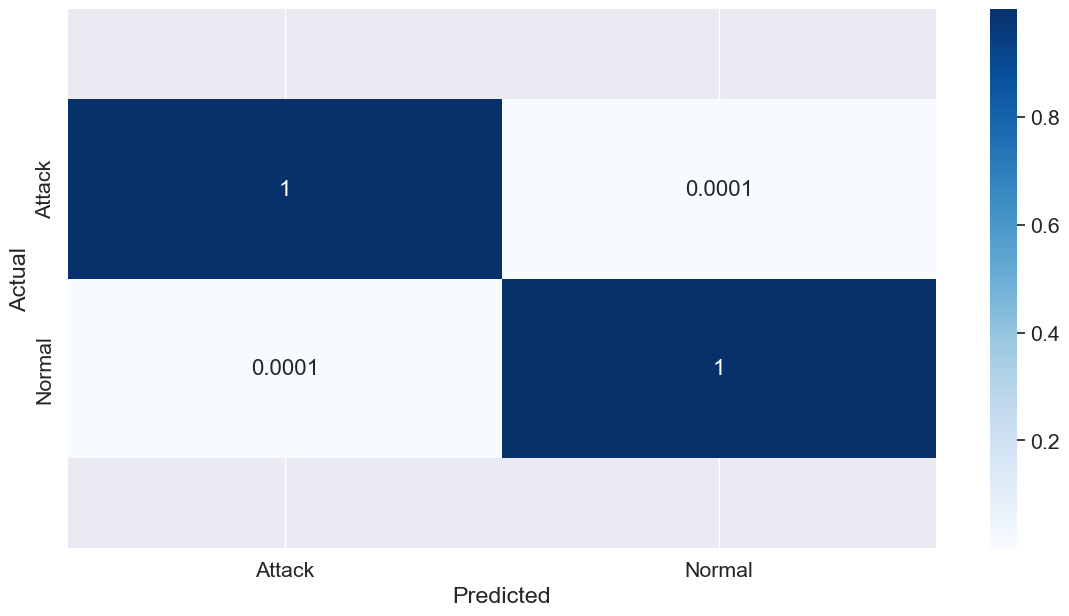

In [16]:


df_cm =  pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4)
plt.figure(figsize = (14,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

### Important features

We can see the degree of contribution of each feature to the classification result by using the __feature\_importances\___ attribute of the Random Forest Classifier. We see here that, as mentioned in the paper, the 10 features extracted from our Adaptive Clustering network consistute the 10 most important features for the classifier.

In [17]:
print("Calculating feature importance scores...")
importances = model.classifier.cls.feature_importances_
indices = np.argsort(importances)[-50:][::-1]  # -50 #most important features
cols = test_df.columns.values.tolist()

feature_importances_list = []
for f in range(len(indices)):
    feature_importances_list.append([indices[f], cols[indices[f]], importances[indices[f]]])

with open(results_path + "rf_feature_importance_scores.pkl", "wb") as f:
    pkl.dump(feature_importances_list, f)
    print(f"Feature importance scores saved: {results_path}rf_feature_importance_scores.pkl")

    print("")
    print("15 most important features")
    pprint(feature_importances_list[:15])
    print("Sum 15:", np.sum(importances[indices[:15]]))
    print("")

Calculating feature importance scores...
Feature importance scores saved: ./results_60/rf_feature_importance_scores.pkl

15 most important features
[[22, 'count', 0.24472342832119298],
 [2, 'service', 0.11632519847299626],
 [5, 'dst_bytes', 0.11319871368540582],
 [11, 'logged_in', 0.09941914667647865],
 [36, 'dst_host_srv_diff_host_rate', 0.05730296820334858],
 [4, 'src_bytes', 0.0505267901281698],
 [23, 'srv_count', 0.047314074397387836],
 [31, 'dst_host_count', 0.046025573469346534],
 [35, 'dst_host_same_src_port_rate', 0.03487531293723757],
 [1, 'protocol_type', 0.03390143422837244],
 [33, 'dst_host_same_srv_rate', 0.030057401888950085],
 [29, 'diff_srv_rate', 0.027462701036502078],
 [30, 'srv_diff_host_rate', 0.01728103073899035],
 [28, 'same_srv_rate', 0.015194449322643177],
 [3, 'flag', 0.01512129748054531]]
Sum 15: 0.9487295209875675



### Performance metrics

Finally, we compute the different performance metrics on our test set. We can see here again that this approach allows us to obtain a perfect score on every single evaluation metric, making this the new state-of-the-art approach for classification tasks.

In [18]:
print("Calculating performance metrics...")
cnf_matrix = confusion_matrix(y_actual_, y_hat)
_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
_tp = np.diag(cnf_matrix)
_tn = cnf_matrix.sum() - (_fp + _fn + _tp)

_fp = _fp.astype(float)
_fn = _fn.astype(float)
_tp = _tp.astype(float)
_tn = _tn.astype(float)

_fp = np.mean(_fp)
_fn = np.mean(_fn)
_tp = np.mean(_tp)
_tn = np.mean(_tn)

metrics_handler = metrics(tp=_tp, tn=_tn, fp=_fp, fn=_fn)
metrics_data = metrics_handler.get_metrics()

accuracy = accuracy_score(y_actual_, y_hat)
precision, recall, f_score, support = prf(y_actual_, y_hat, average='weighted')
print("Accuracy : {:0.7f}, Precision : {:0.7f}, Recall : {:0.7f}, F-score : {:0.7f}, FAR: {:0.7f}"
                                                      .format(accuracy, precision,
                                                              recall, f_score, metrics_data["FAR"]))

with open(results_path + "metrics_handler.pkl", "wb") as f:
    pkl.dump(metrics_handler, f)
    print(f"Performance metrics saved: {results_path}metrics_handler.pkl")




Calculating performance metrics...
Accuracy : 0.9999429, Precision : 0.9999429, Recall : 0.9999429, F-score : 0.9999429, FAR: 0.0000571
Performance metrics saved: ./results_60/metrics_handler.pkl


### GRAPHES



losses: [12.669425809383393, 12.627153468132018, 12.587103033065796, 12.569382083415984, 12.574576592445373, 12.570674908161163, 12.53535053730011, 12.538687062263488, 12.514211118221283, 12.517251932621003, 12.498751258850097, 12.465415728092193, 12.459144032001495, 12.429590952396392, 12.421732187271118, 12.415694463253022, 12.410933375358582, 12.391676473617554, 12.360683476924896, 12.377760136127472, 12.351369845867158, 12.3483416557312, 12.346613562107086, 12.34400099515915, 12.347279667854309, 12.312949514389038, 12.312743139266967, 12.284543013572693, 12.284266018867493, 12.29839723110199, 12.286505961418152, 12.254962611198426, 12.24619926214218, 12.231947791576385, 12.224848687648773, 12.195660626888275, 12.205633699893951, 12.192036736011506, 12.17917788028717, 12.177059864997863, 12.162591147422791, 12.159516668319702, 12.137276887893677, 12.126532351970672, 12.107413339614869, 12.100515675544738, 12.125263452529907, 12.127591204643249, 12.11474050283432, 12.088151121139527,

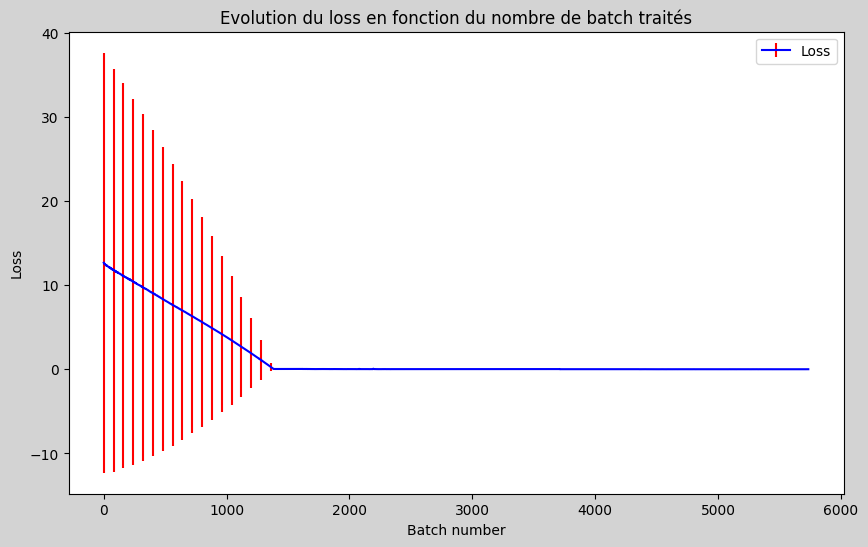

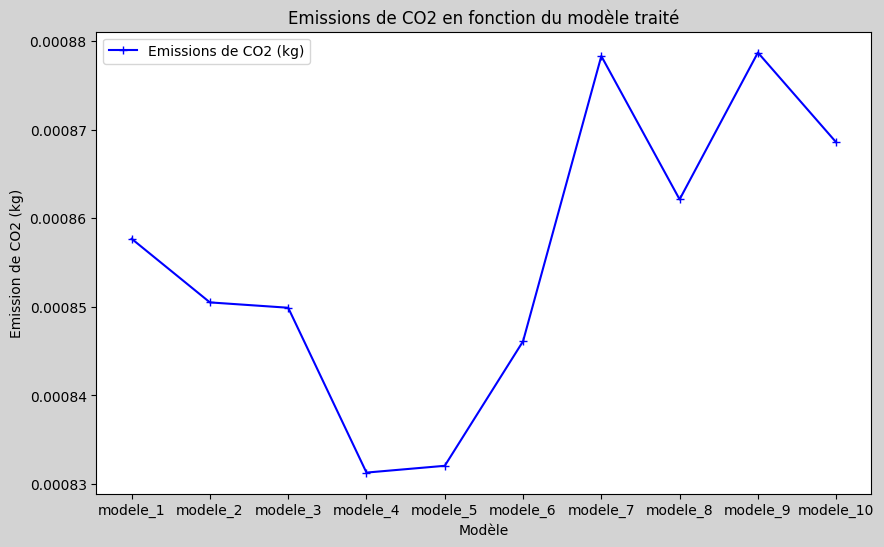

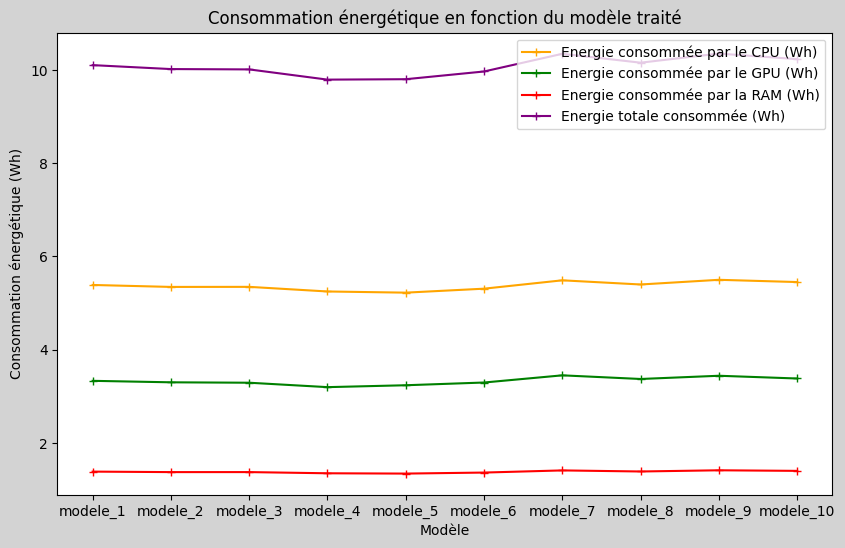

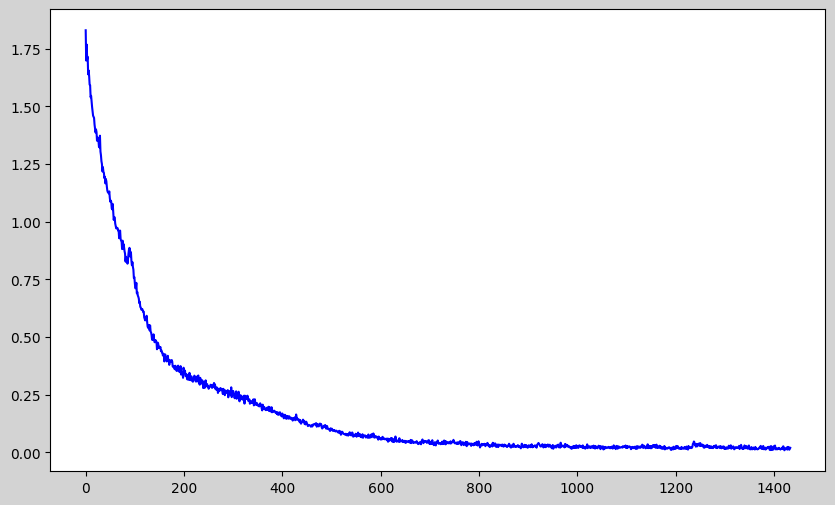

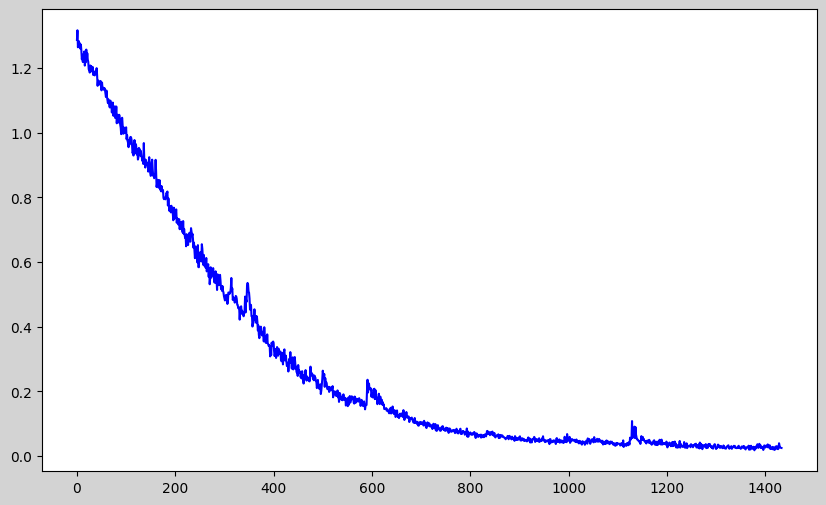

In [6]:
couleurs = ['blue','orange','green','red']

import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st
import statistics as stat
import os
import sys

def confidence_interval(data,confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    se = st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2.,n-1)
    return h



with open(results_path+"jeu_de_donnees/dic_loss.pkl", 'rb') as file:
    dic_loss = pkl.load(file)


x = range(len(dic_loss["entrainement_1"]['epoch_0'])*4)

plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

#init losses
losses = {j: [0 for i in range(len(dic_loss["entrainement_1"]["epoch_0"]))] for j in dic_loss["entrainement_1"].keys()}


#Calcul de la somme des losses pour chaque tentative et à chaque epoch
for tentative in dic_loss.keys():
    # print(tentative)
    for epoch in dic_loss[tentative].keys():
        # print(epoch)
        for v_loss in range(len(losses[epoch])):
            # print(f"loss courant: {losses[epoch][v_loss]} / somme: {dic_loss[tentative][epoch][v_loss]}")
            losses[epoch][v_loss] += dic_loss[tentative][epoch][v_loss]

#Mise à jour du dico loss
# losses = {j: [i/len(dic_loss.keys()) for i in losses[j]] for j in dic_loss["entrainement_1"].keys()}
losses = {"valeurs" : losses["epoch_0"] + losses["epoch_1"] + losses["epoch_2"] + losses["epoch_3"]}
losses = [i/len(dic_loss.keys()) for i in losses["valeurs"]]

with open(results_path+"jeu_de_donnees/moyenne_loss.pkl", 'wb') as fichier:
    pkl.dump(losses,fichier)

print("losses:",losses)

#Préparation des barres d'erreurs
# print("std_loss")
std_loss = []
transfert = {i : dic_loss[i]["epoch_0"]+dic_loss[i]["epoch_1"]+dic_loss[i]["epoch_2"]+dic_loss[i]["epoch_3"] for i in dic_loss.keys()}

for i in range(len(transfert["entrainement_1"])):
    data = [transfert[j][i] for j in transfert.keys()]
    std_loss.append(confidence_interval(data))


plt.errorbar(x, losses, yerr=[std_loss[i] if (i%80==0) else 0 for i in range(len(losses))],label="Loss",color=couleurs[0], ecolor='red')
             
                 
#Graphe général
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Evolution du loss en fonction du nombre de batch traités')
plt.legend()
plt.savefig(results_path + './courbes/loss_evolution_with_uncertainty_4epochs.png')  # Sauvegarder la figure



# with open(results_path+"jeu_de_donnees/"+"moyenne_loss.pkl", 'wb') as file:
#         pkl.dump(losses, file)
with open(results_path+"jeu_de_donnees/"+"std_loss.pkl", 'wb') as file:
        pkl.dump(std_loss, file)


#Partie émissions
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
liste_x = []
liste_emissions_y = []
liste_cpu_energy_y = []
liste_gpu_energy_y = []
liste_ram_energy_y = []
liste_total_energy_y = []

with open(results_path+"emissions.csv", "r") as csvfile:
    lecteur = csv.DictReader(csvfile, delimiter=',')
    for ligne in lecteur:
        print(ligne)
        if ligne['project_name'] != "initialisation":
            liste_emissions_y.append(float(ligne["emissions"]))
            liste_cpu_energy_y.append(float(ligne["cpu_energy"])*1000)
            liste_gpu_energy_y.append(float(ligne["gpu_energy"])*1000)
            liste_ram_energy_y.append(float(ligne["ram_energy"])*1000)
            liste_total_energy_y.append(float(ligne["energy_consumed"])*1000)
            liste_x.append(ligne['project_name'])



plt.plot(liste_x,liste_emissions_y,label="Emissions de CO2 (kg)",color="blue",marker='+')
plt.xlabel('Modèle')
plt.ylabel('Emission de CO2 (kg)')
plt.title('Emissions de CO2 en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/emission_Co2.png')

#partie consommation
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

plt.plot(liste_x,liste_cpu_energy_y,label="Energie consommée par le CPU (Wh)",color="orange",marker='+')
plt.plot(liste_x,liste_gpu_energy_y,label="Energie consommée par le GPU (Wh)",color="green",marker='+')
plt.plot(liste_x,liste_ram_energy_y,label="Energie consommée par la RAM (Wh)",color="red",marker='+')
plt.plot(liste_x,liste_total_energy_y,label="Energie totale consommée (Wh)",color="purple",marker='+')

plt.xlabel('Modèle')
plt.ylabel('Consommation énergétique (Wh)')
plt.title('Consommation énergétique en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/conso_electrique.png')

plt.show()

#Conservation des données
dico_enviro = {}
dico_enviro["emissions"] = liste_emissions_y
dico_enviro["cpu_energy"] = liste_cpu_energy_y
dico_enviro["gpu_energy"] = liste_gpu_energy_y
dico_enviro["ram_energy"] = liste_ram_energy_y
dico_enviro["total_energy"] = liste_total_energy_y
dico_enviro["liste_x"] = liste_x

with open(results_path+"jeu_de_donnees/"+"dico_enviro.pkl", 'wb') as file:
        pkl.dump(dico_enviro, file)

#ARRANGER LE CODE ICI PAR RAPPORT AU FICHIER CSV DES EMISSIONS PUIS FAIRE CELUI AVEC 50 NEURONES

plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
plt.plot(range(len(dic_loss["entrainement_1"]["epoch_0"])),dic_loss["entrainement_1"]["epoch_0"],label="Test",color="blue")

plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
plt.plot(range(len(dic_loss["entrainement_2"]["epoch_0"])),dic_loss["entrainement_2"]["epoch_0"],label="Test",color="blue")